In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import utils

In [3]:
import Cat_aug
import LR_aug
import SVC_aug
import SVR_aug
import XGB_aug
import single_layer_aug
import gp_aug

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [5]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [6]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [8]:
object_ids = np.unique(data.object_id)

In [9]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

In [10]:
ss = StandardScaler()

# Visual analysis

In [11]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [12]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [13]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [14]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [15]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [16]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    plt.show()

In [17]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

In [18]:
def hist(object_column):
    plt.figure(figsize=(9, 4))
    hist_object = np.array(object_column)
    plt.hist(hist_object, density=True, bins=30)
    plt.ylabel('Probability')
    plt.xlabel('Data');
    plt.title("Histogram MAPE");
    plt.show()

In [19]:
def highlight_min(x):
    return ['font-weight: bold' if v == x.min() else ''
                for v in x]

In [20]:
def approximate_model(reg, anobject):
    
    anobject = flux_not_negativ(anobject)
    reg.fit(anobject['mjd'].values, anobject['flux'].values, 
            anobject['flux_err'].values, anobject['passband'].values)

    approx_object = create_approx_object(anobject)
    approx_object['flux'], approx_object['flux_err'] = reg.predict(approx_object['mjd'].values, approx_object['passband'].values)
    
    return approx_object

In [21]:
def plot_light_curves_compare(orig_object, approx_objects, titles=None):
    if titles is None:
        titles = [""] * (1 + len(approx_objects))
    plot_light_curves(orig_object, titles[0])
        
    plt.figure(figsize=(20, 15))
    n_obj = len(approx_objects)
    for idx, anobject in enumerate(approx_objects, 1):
        plt.subplot(4, n_obj//4 + 1, idx)
        anobject = anobject.sort_values('mjd')
        for passband in range(6):
            light_curve = get_passband(anobject, passband)
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
            plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
        plt.subplots_adjust(hspace=1) 
        plt.xlabel('Modified Julian Date', size=14)
        plt.xticks(size=14, rotation=45)
        plt.ylabel('Flux', size=14)
        plt.yticks(size=14)
        plt.legend(loc='best', ncol=3, fontsize=14)
        plt.title(titles[idx], size=14)
    plt.show()

In [22]:
def flux_not_negativ(anobject):
    anobject_new = anobject.copy()
    anobject_new['flux'] = np.where(anobject_new['flux'] < 0, 0, anobject_new['flux'])
    return anobject_new

In [23]:
def report_model(name_model):
    report_mean = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'TIME'])
    #report_std = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])
    for i in object_ids: 
        start = time.time()
        # get an object
        anobject = get_object(data, i)
        anobject = add_log_lam(anobject)

        if not is_good(anobject): continue

        # train / test split
        anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

        if name_model == 'SVC':
            model = SVC_aug.SupportVectorClassificationAugmentation(passband2lam)
        if name_model == 'SVR':
            model = SVR_aug.SupportVectorRegressionAugmentation(passband2lam)
        if name_model == 'XGB':
            model = XGB_aug.XGBRegressionAugmentation(passband2lam)
        if name_model == 'Cat':
            model = Cat_aug.CatBoostRegressorAugmentation(passband2lam)
        if name_model == 'NN_1':
            model = single_layer_aug.SingleLayerNetAugmentation(passband2lam)
        if name_model == 'GP':
            model = gp_aug.GaussianProcessesAugmentation(passband2lam)
        if name_model == "LR" or name_model == "Lasso" or name_model == 'Ridge' or name_model == "ElasticNet":
            model = LR_aug.LinearRegressionAugmentation(passband2lam, mod=name_model)
        
        model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)
        
        flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values)

        t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), anobject['mjd'].max(), n_obs=1000)

        anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, flux_err_pred, anobject_test['passband'].values)

        metrics_mean = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
        #metrics_std = utils.regression_quality_metrics_report(anobject_test['flux_err'].values, anobject_test_pred['flux_err'].values)
        diff = time.time() - start
        report_mean.loc[len(report_mean), :] = [i] + list(metrics_mean) + [diff]
        #report_std.loc[len(report_std), :] = [i] + list(metrics_std)
    
    return report_mean #, report_std
    

In [24]:
def add_report(df, mod_mean, mod_std, first_metric):
    error = ['MODEL', 'TIME']
    if first_metric in error:
        df[first_metric]['mean'] =  mod_mean[first_metric]
    else:
        df[first_metric]['mean'] =  mod_mean[first_metric]
        df[first_metric]['std'] =  mod_std[first_metric]

34299


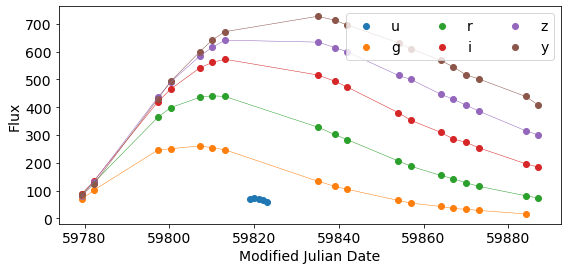

43812


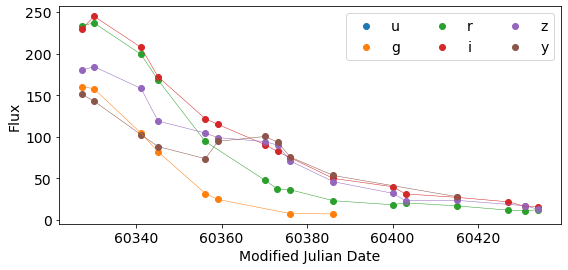

70046


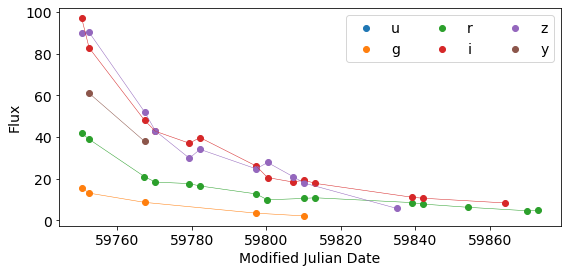

84716


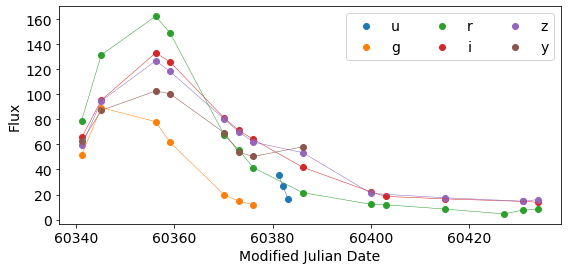

131629


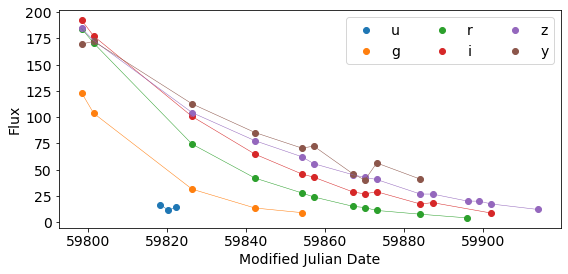

169315


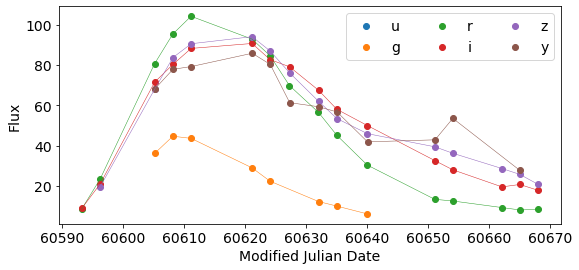

229855


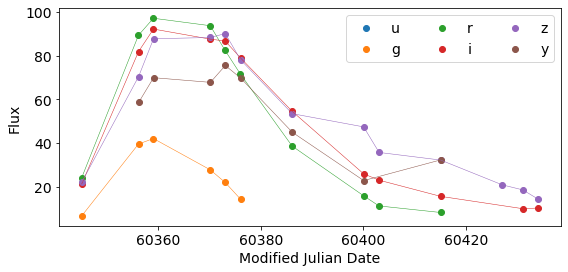

251430


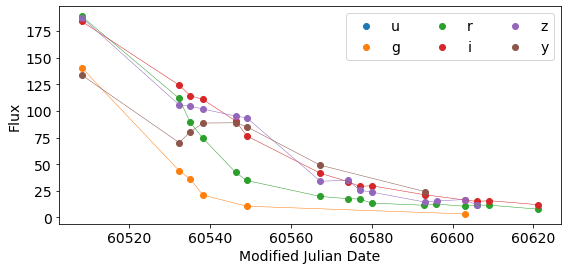

282714


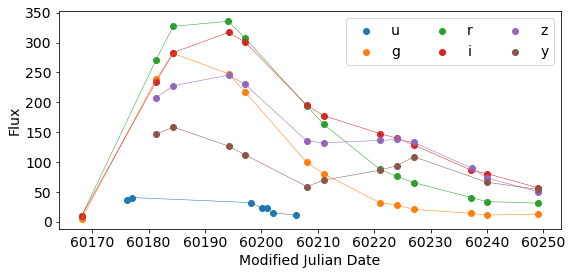

290682


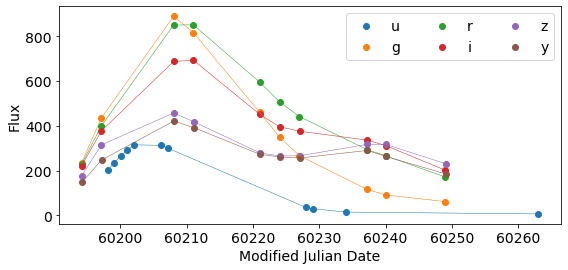

316306


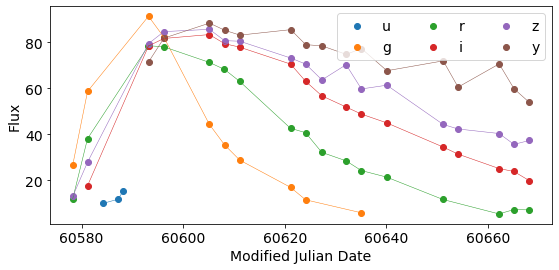

In [25]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)

# Test

In [26]:
models = [
    'LR',
    'Lasso',
    'Ridge',
    'ElasticNet',
    'SVC',
    'SVR',
    'XGB',
    'NN_1',
    'GP',
    'Cat'
]
print(models)
metric = ['RMSE', 'RMSE', 'MAE', 'MAE', 'RSE', 'RSE', 'RAE', 'RAE', 'MAPE', 'MAPE']
unit_metric = list(set(metric))
second_metric = ["mean" if i%2==0 else 'std'
                 for i in range(len(metric))]
arr = [np.array(['MODEL']+metric+['TIME']), np.array(['mean']+second_metric+['mean'])]
report = pd.DataFrame(None, columns=arr) #, index=models
for index in range(len(models)):
    report_mod_mean = report_model(name_model=models[index])
    report_mod_mean = report_mod_mean.drop('ID', 1)
    for j in unit_metric:
        report.loc[index, (j, 'mean')] = report_mod_mean[j].mean()
        report.loc[index, (j, 'std')] = report_mod_mean[j].std()
    report.loc[index, ('TIME', 'mean')] = report_mod_mean['TIME'].mean()
    report.loc[index, ('MODEL', 'mean')] = models[index]

['LR', 'Lasso', 'Ridge', 'ElasticNet', 'SVC', 'SVR', 'XGB', 'NN_1', 'GP', 'Cat']


In [27]:
report

MODEL     RMSE               MAE                RSE            \
         mean     mean      std     mean      std      mean       std   
0          LR  120.346  607.461   51.677  169.786   1.87515   12.1382   
1       Lasso   72.676  247.503  51.1549  152.679  0.631402    0.1571   
2       Ridge   55.906  183.867   39.091  113.892  0.506273   0.17832   
3  ElasticNet  67.1016   225.35  46.5389  141.384  0.581464   0.16956   
4         SVC   49.982  144.594  28.5234  68.6036  0.495147   0.20734   
5         SVR  34.4843  158.697  20.0536  89.4571   0.31087  0.164717   
6         XGB   36.454  128.311  22.0306  62.9583  0.387725  0.171481   
7        NN_1  36.9265  136.077  24.4818  88.3071  0.341486  0.161193   
8          GP  26.2824   165.57  14.5431  65.5736  0.244213  0.151135   
9         Cat  29.7575  108.744  17.9659  54.2774  0.310658  0.128578   

        RAE                MAPE                TIME  
       mean        std     mean      std       mean  
0  0.818906    3.19141  340.899  2366.73  0.0153923  
1  0.583953   0.160069  80.9563  74.9257  0.0162692  
2   0.46288   0.173248   53.997   57.326  0.0169279  
3  0.525032   0.168362  66.6316  73.2136  0.0161666  
4  0.385923   0.148057  34.0165  24.4024  0.0399046  
5  0.243609   0.118526   26.905  26.1859  0.0153576  
6  0.317342   0.126769  29.6101  18.9374   0.081729  
7  0.292645   0.129643  30.5248  28.1023    1.40731  
8  0.200338   0.110905  24.8672  22.4916    0.20763  
9  0.255625  0.0991442  25.4885   17.123   0.574472

In [28]:
report.index = report['MODEL']['mean']
report.index.name = 'MODEL'

In [29]:
report = report.drop('MODEL', axis=1)

In [30]:
report = report.style.apply(highlight_min)

In [31]:
report

In [32]:
report.to_excel('model_table.xlsx')

34299


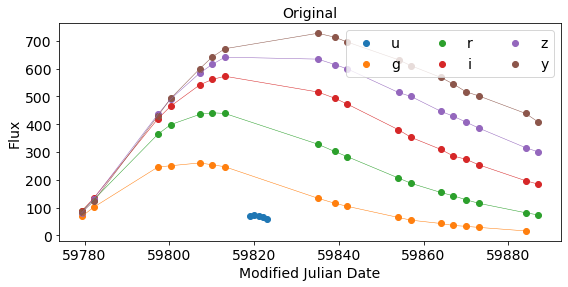

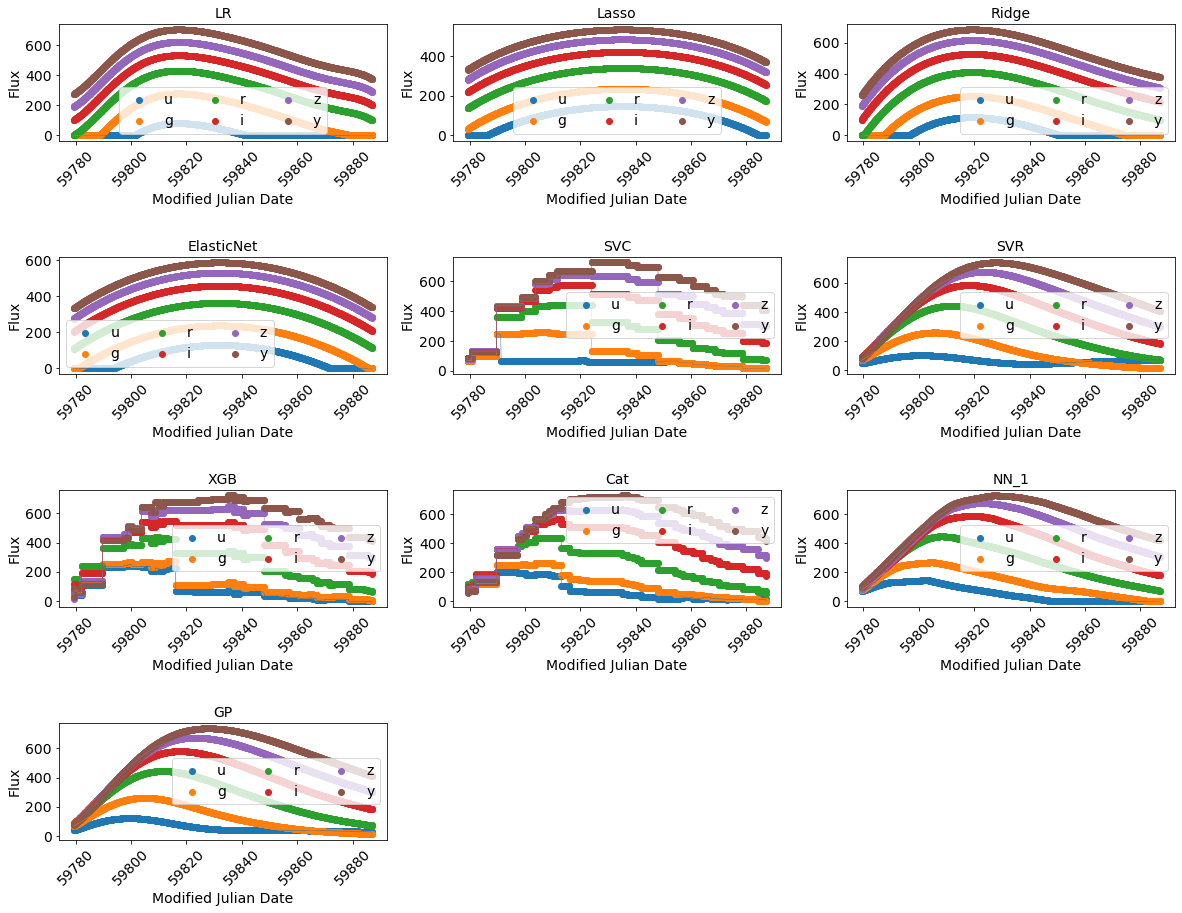

43812


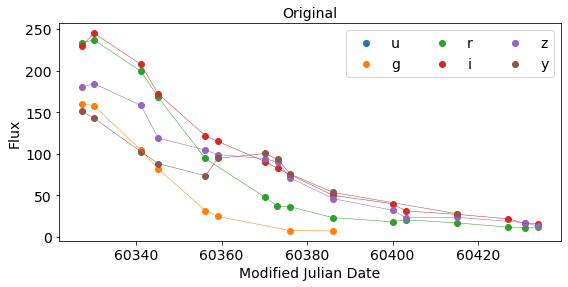

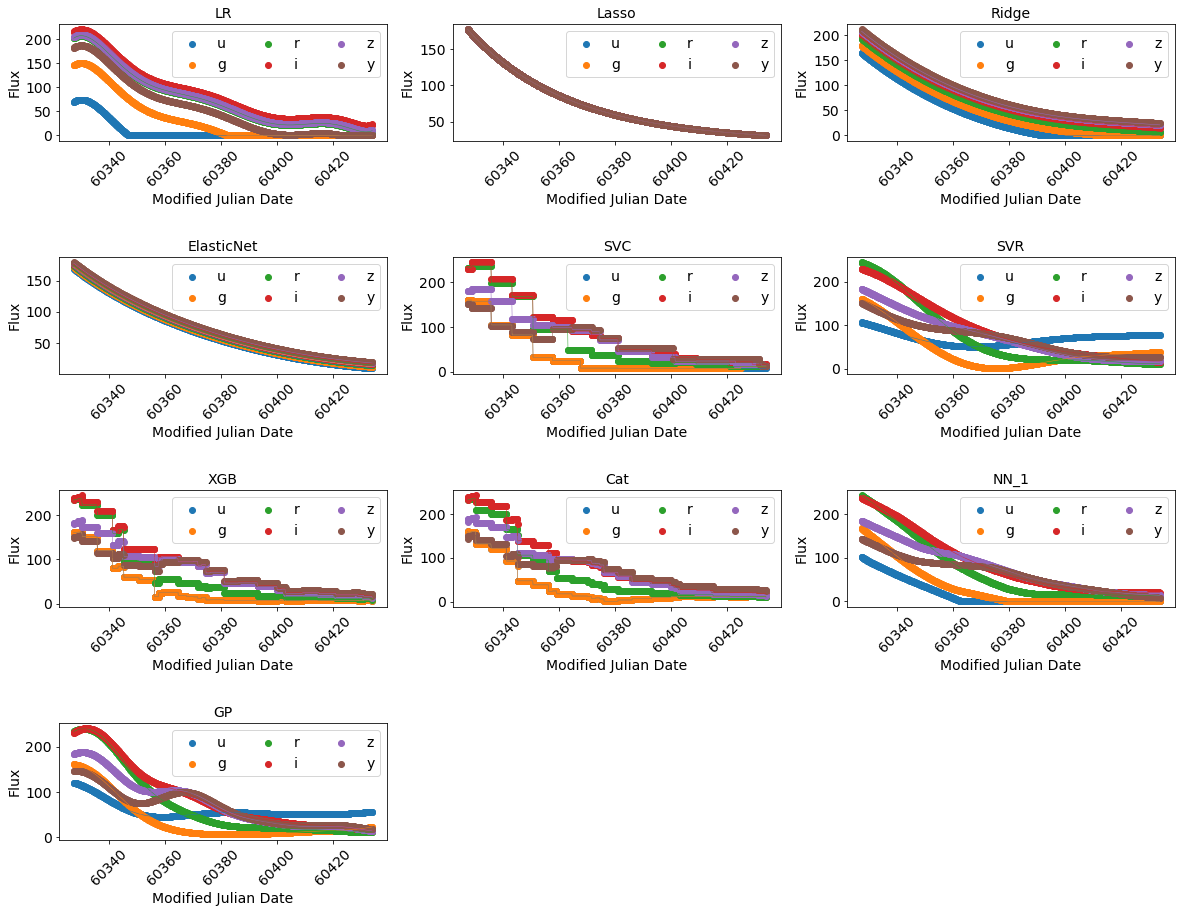

70046


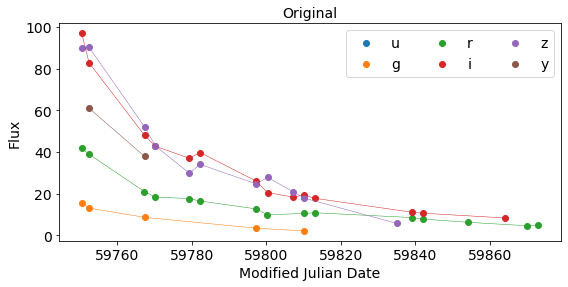

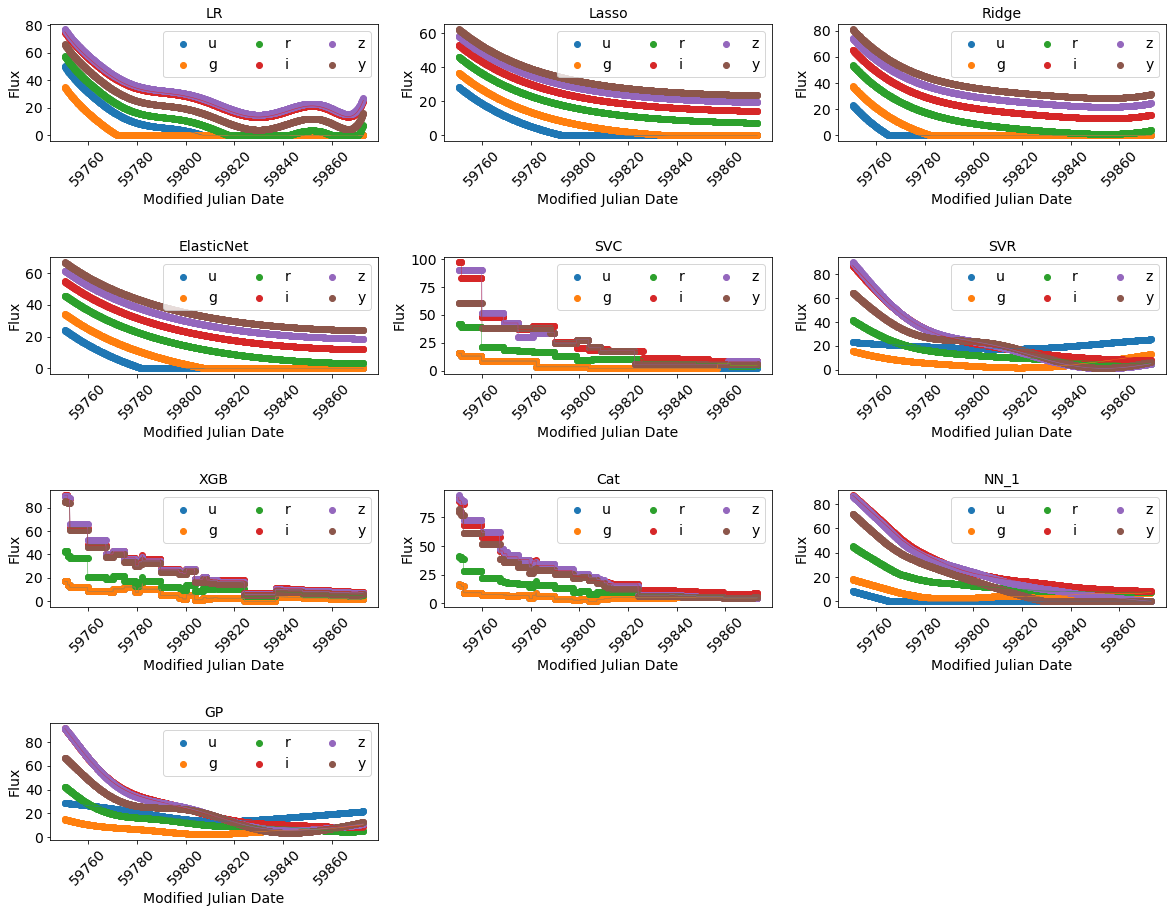

84716


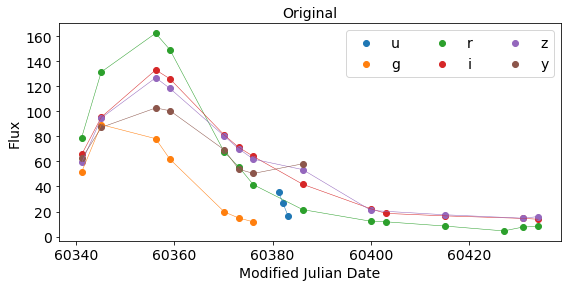

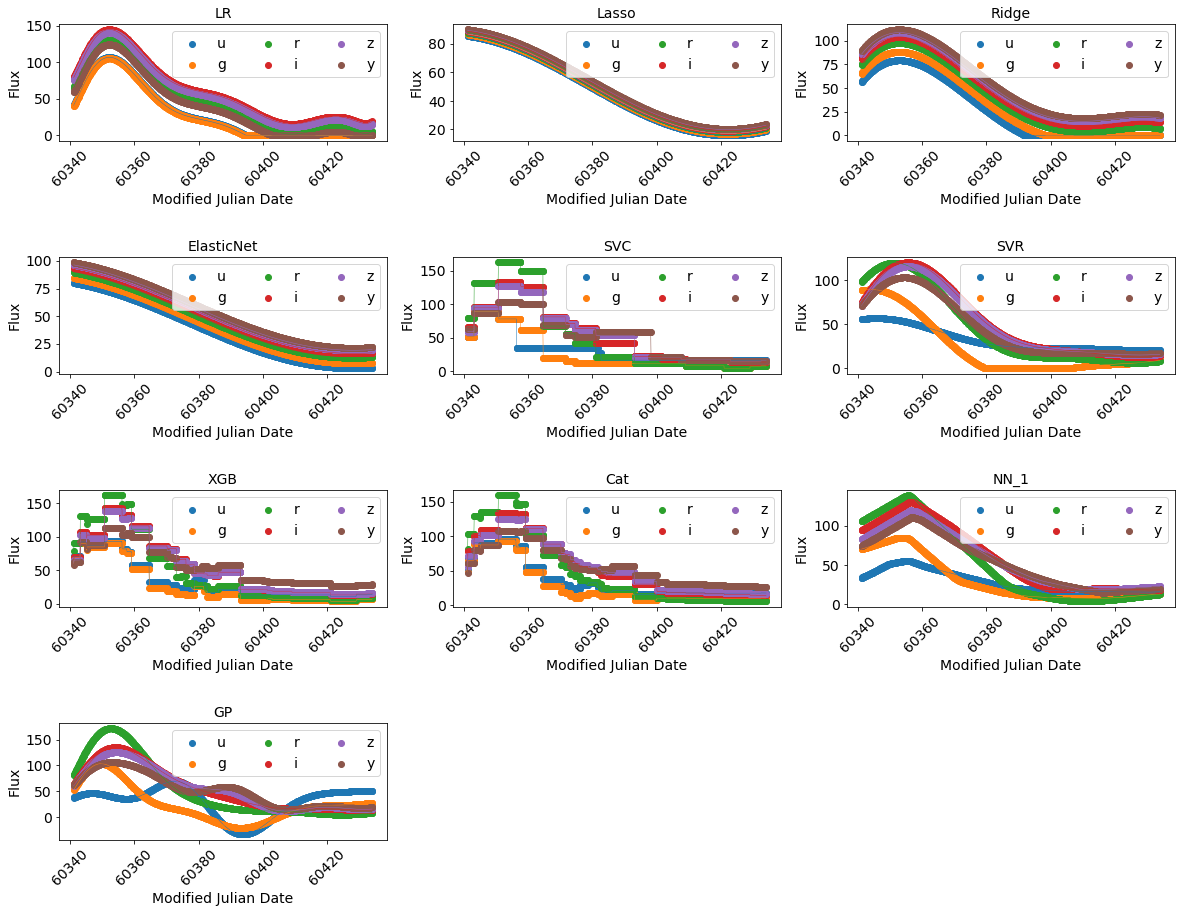

131629


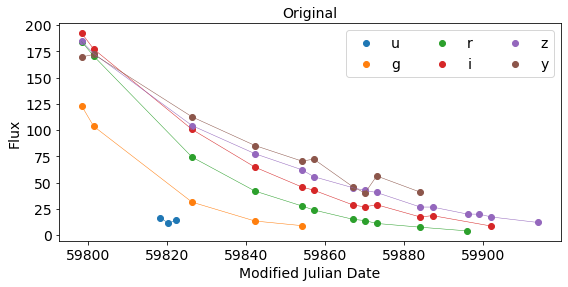

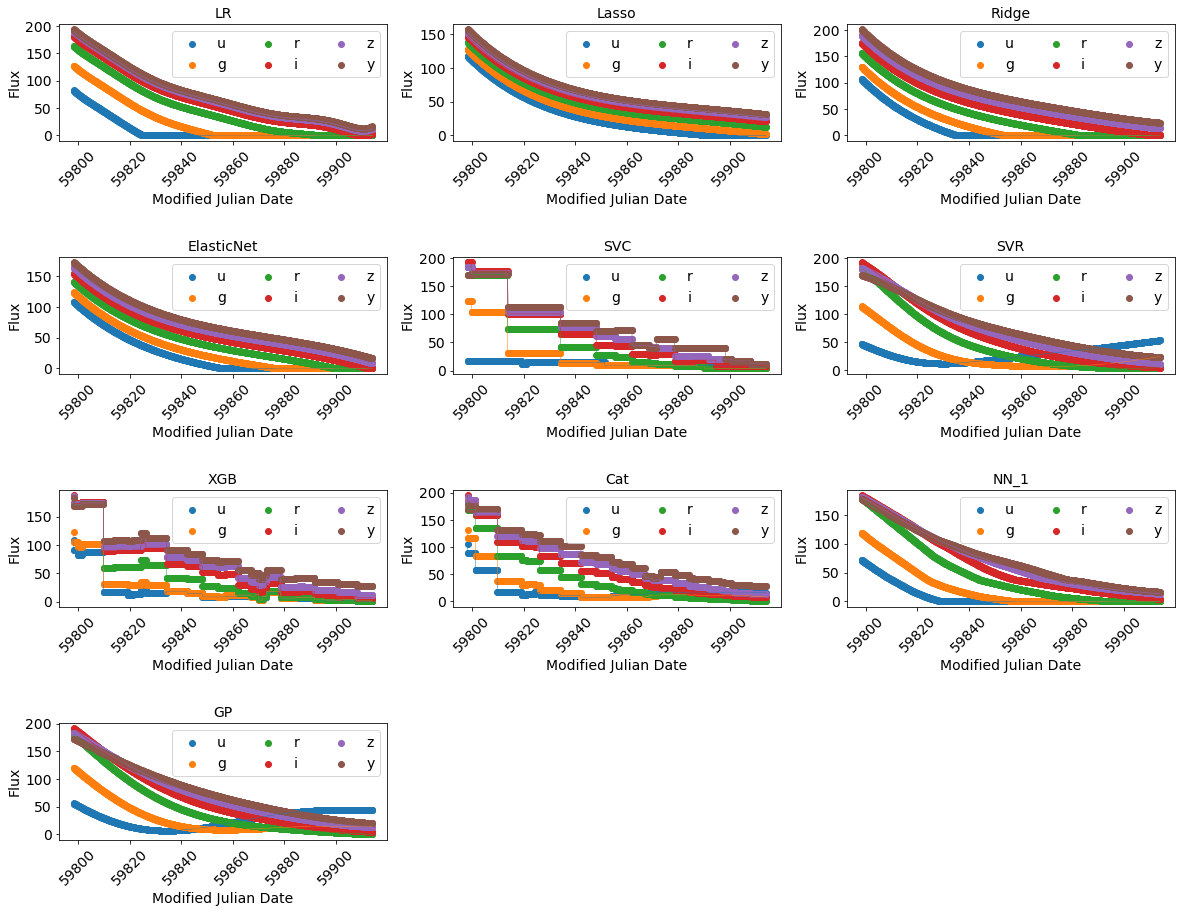

169315


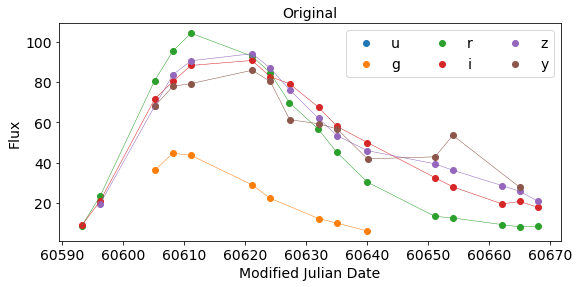

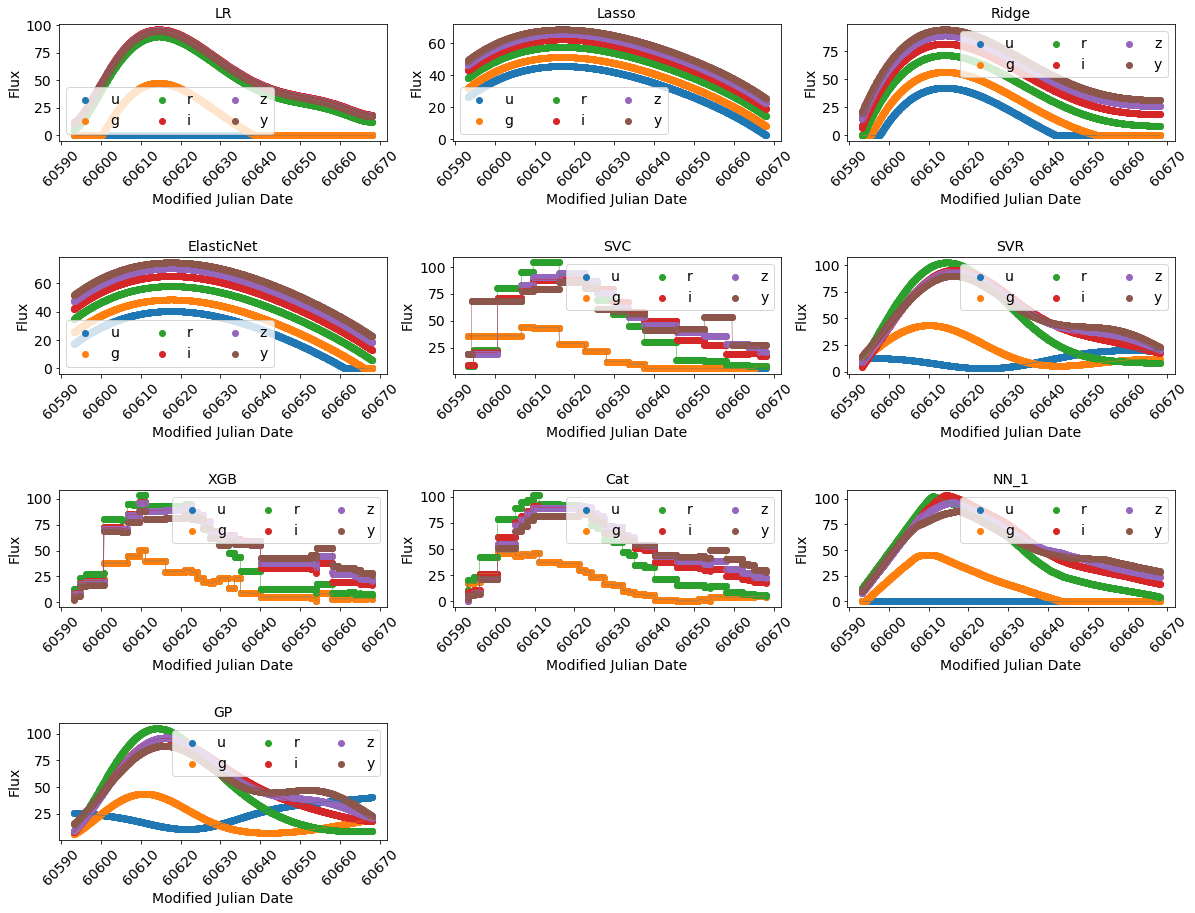

229855


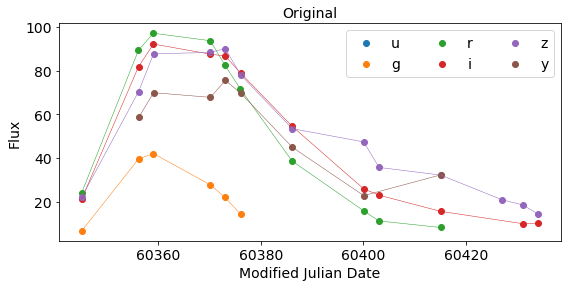

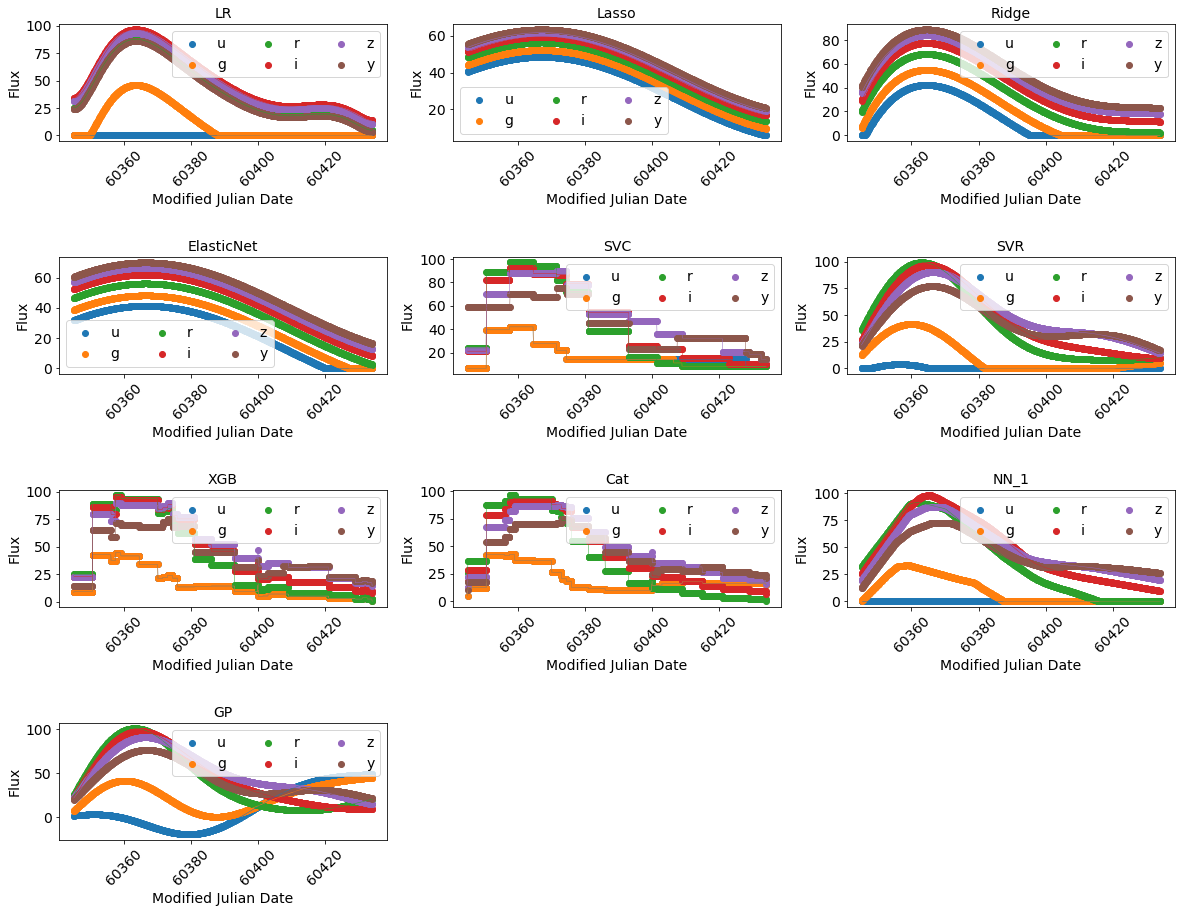

251430


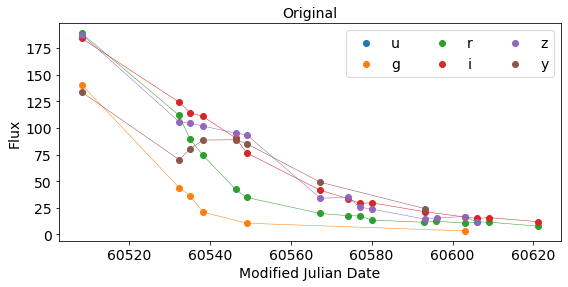

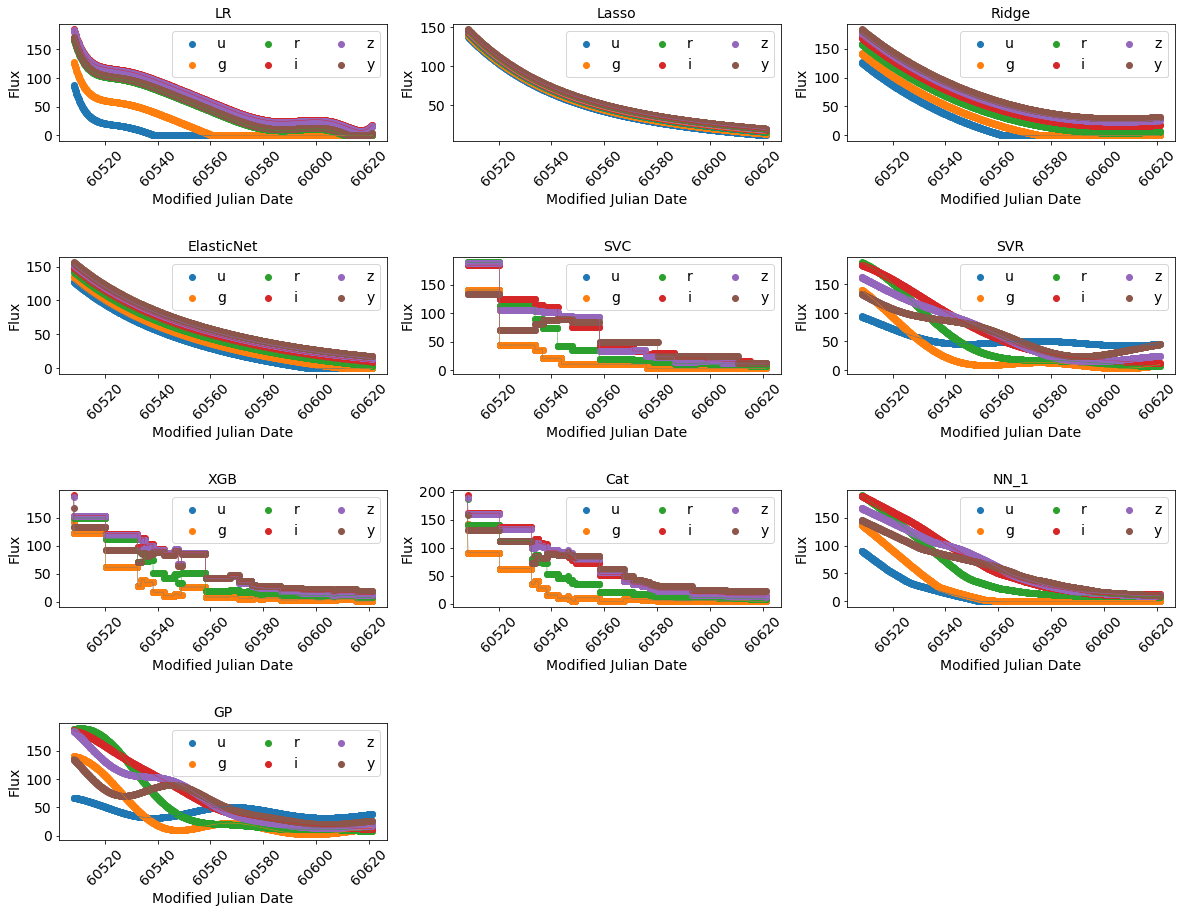

282714


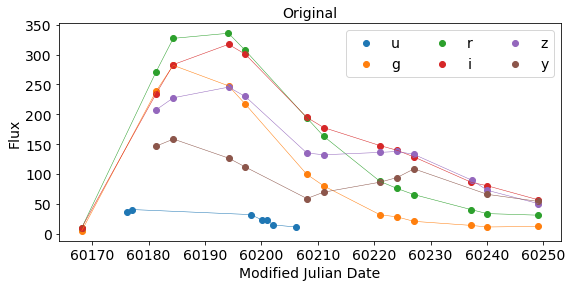

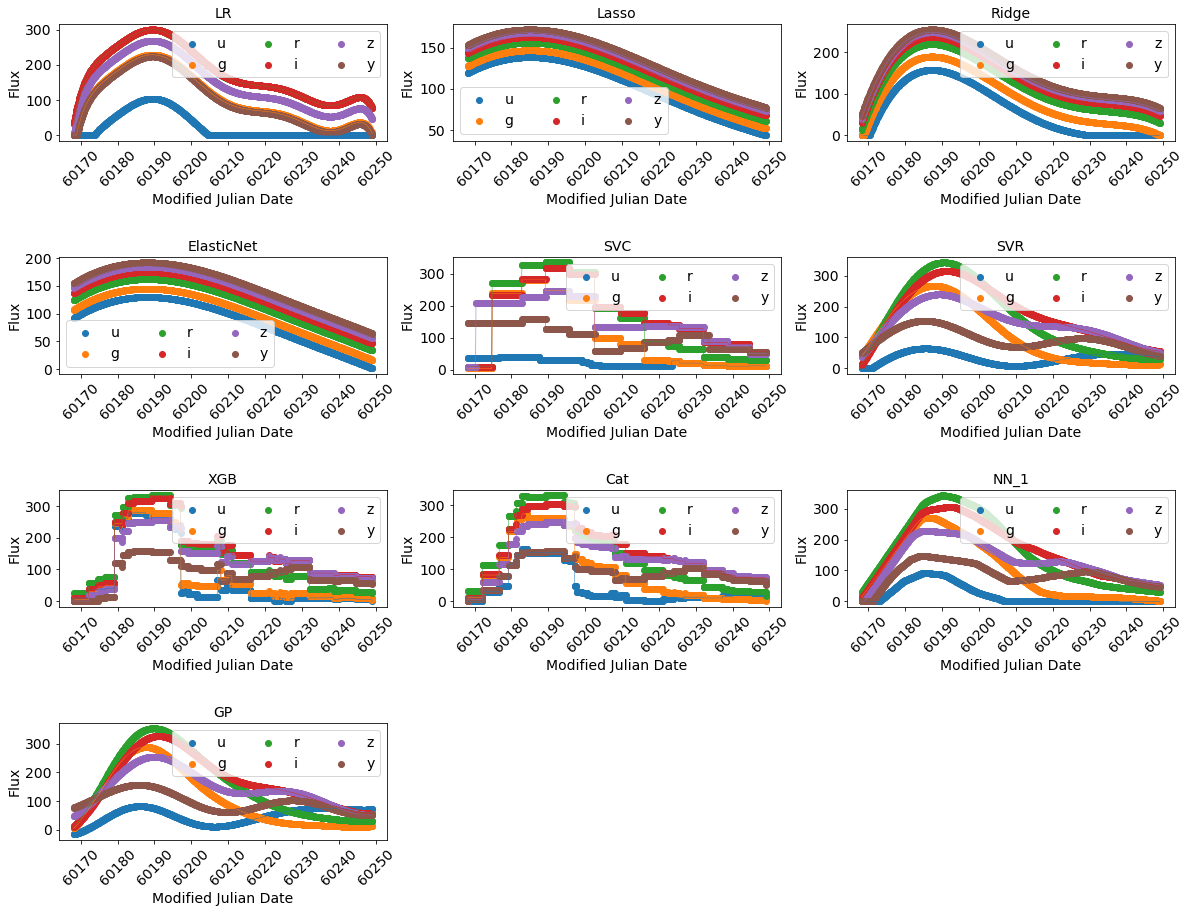

290682


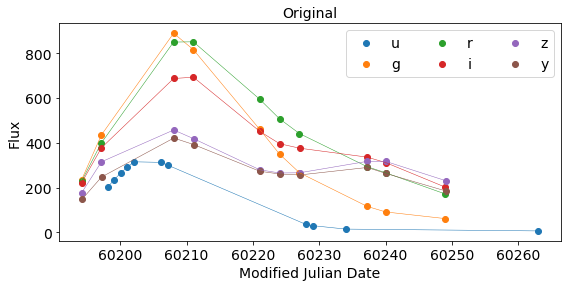

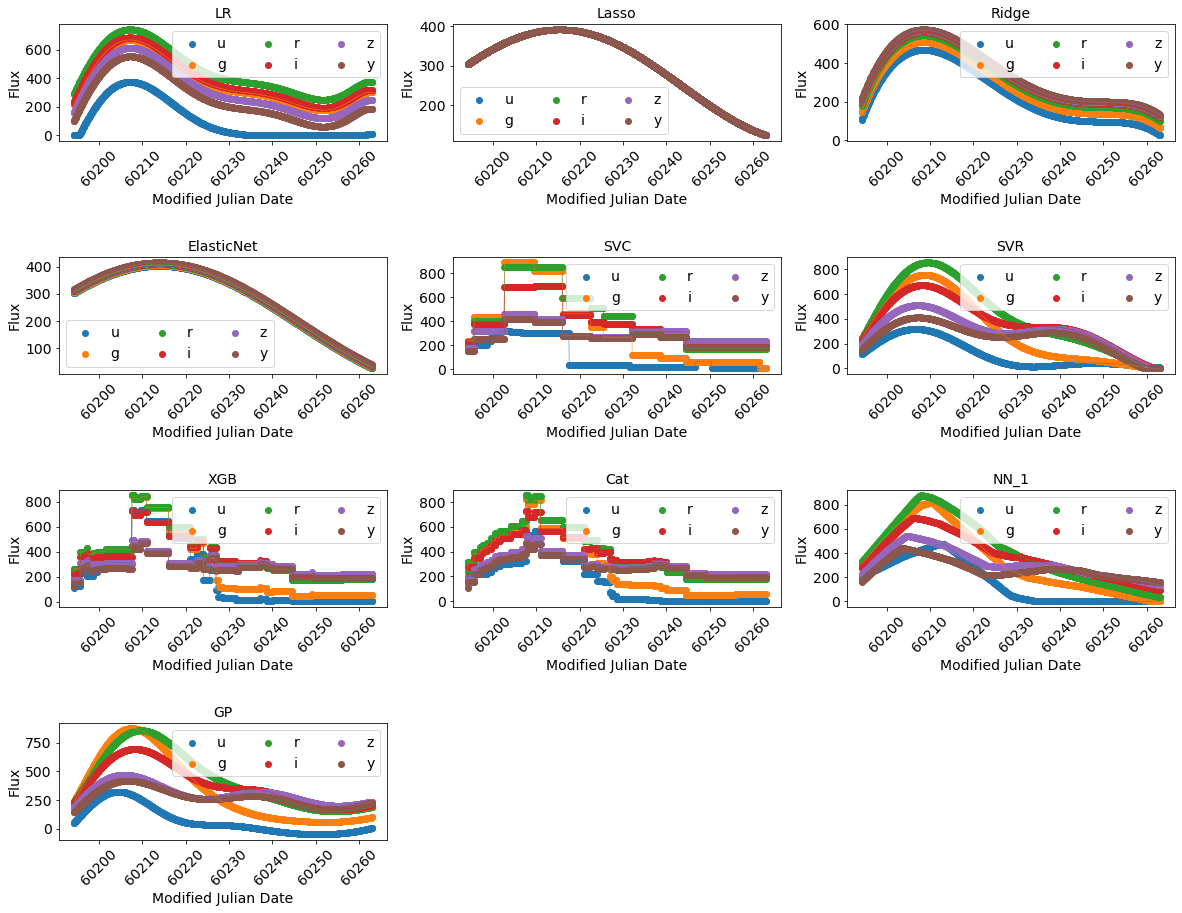

316306


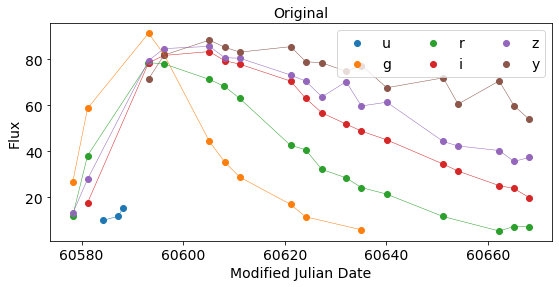

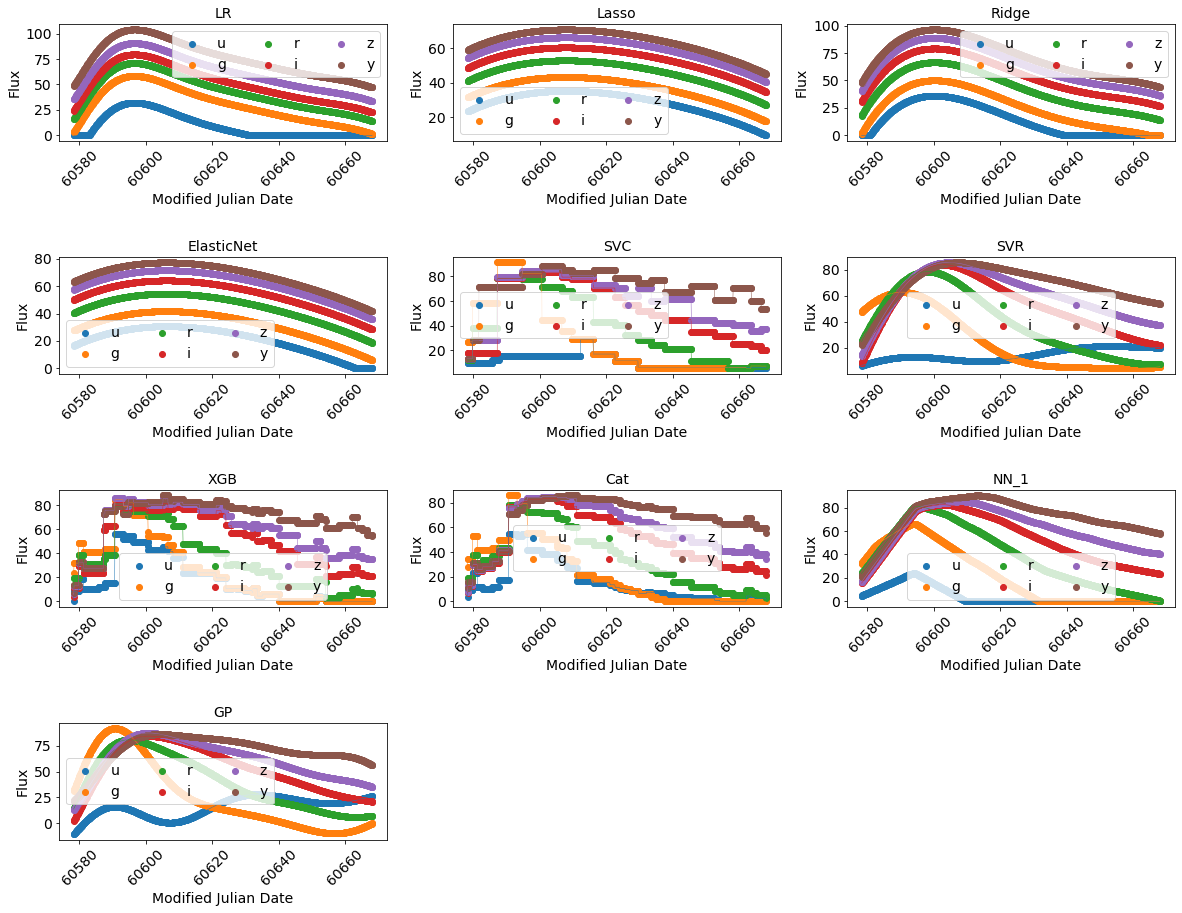

In [33]:
regs = [
    LR_aug.LinearRegressionAugmentation(passband2lam, "LR"),
    LR_aug.LinearRegressionAugmentation(passband2lam, "Lasso"),
    LR_aug.LinearRegressionAugmentation(passband2lam, "Ridge"),
    LR_aug.LinearRegressionAugmentation(passband2lam, "ElasticNet"),
    SVC_aug.SupportVectorClassificationAugmentation(passband2lam),
    SVR_aug.SupportVectorRegressionAugmentation(passband2lam),
    XGB_aug.XGBRegressionAugmentation(passband2lam),
    Cat_aug.CatBoostRegressorAugmentation(passband2lam),
    single_layer_aug.SingleLayerNetAugmentation(passband2lam),
    gp_aug.GaussianProcessesAugmentation(passband2lam)
]
for i in object_ids[::50]:
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)

    if not is_good(anobject): continue
    print(i)

    objects = [approximate_model(reg, anobject) for reg in regs]
    
    plot_light_curves_compare(anobject, objects, ['Original', 'LR', 'Lasso', 'Ridge', 'ElasticNet', 'SVC', 'SVR', 'XGB','Cat', 'NN_1', 'GP'])
    plt.show()